In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os

from astropy.time import Time
from matplotlib import gridspec

from IPython.display import display
from ipywidgets import interact, widgets

Input parameters required:
* Full path to data file containing timestamps and velocity channels of interest
* Julian date format for timestamp conversion
* Observation epoch

Expected input format is comma separated data columns containing timeseries of spectra over velocity per channel

In [2]:
input_file = widgets.Text(value='data/iktausRAW_blue_red_channels.tscat',
                          placeholder='Type full path to HartRAO data file here',
                          description='filename:',
                          disabled=False,
                          layout={'width':'405px'},
                         )
input_tsfmt = widgets.Dropdown(value='mjd',
                               options=['mjd', 'jd'],
                               description='JD format:',
                               disabled=False,
                               layout={'width':'200px'},
                              )
input_epoch = widgets.Text(value='0',
                           placeholder='epoch',
                           description='epoch:',
                           disabled=False,
                           layout={'width':'200px'},
                          )
options = widgets.HBox([input_tsfmt, input_epoch])
ui = widgets.VBox([input_file, options])
display(ui)

VkJveChjaGlsZHJlbj0oVGV4dCh2YWx1ZT11J2RhdGEvaWt0YXVzUkFXX2JsdWVfcmVkX2NoYW5uZWxzLnRzY2F0JywgZGVzY3JpcHRpb249dSdmaWxlbmFtZTonLCBsYXlvdXQ9TGF5b3V0KHfigKY=


In [3]:
filename = input_file.value
tsformat = input_tsfmt.value
epoch = float(input_epoch.value)
print("Reading OH monitoring file {} using epoch {} and '{}' format for time interpretation".
      format(filename, epoch, tsformat.upper()))

Reading OH monitoring file data/iktausRAW_blue_red_channels.tscat using epoch 0.0 and 'MJD' format for time interpretation


In [4]:
import hart_io as io
# read input data assuming HartRAO format
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(filename,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [5]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')

IKTAU        OH1612 time series of intensities F from iktaus.sf85
MJD, 17.368, 50.373

Spectral data size (#ts, #ch) = (205, 2)


In [6]:
blue_spectrum = spectra[:, 0]
blue_velocity = chan_vel[0]
red_spectrum = spectra[:, 1]
red_velocity = chan_vel[1]
jd_datetime = ts_jd.datetime

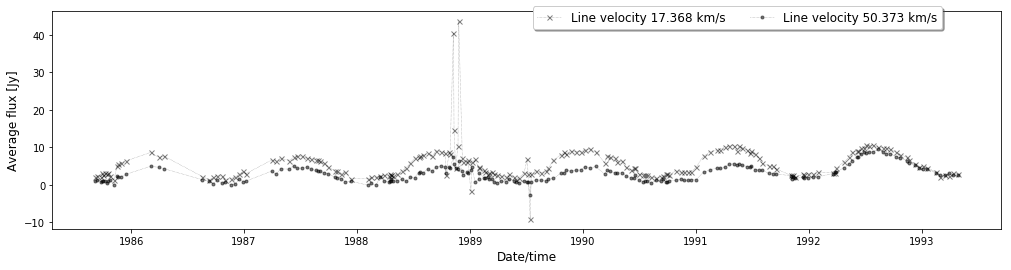

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum,
        color='k', marker='x', linestyle=':', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(jd_datetime, red_spectrum,
        color='k', marker='.', linestyle=':', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

Setting up for cleaning using smoothing and detrending techniques

In [8]:
input_window = widgets.Text(value='21',
                            placeholder='window',
                            description='window',
                            disabled=False,
                            layout={'width':'150px'},
                           )
input_threshold = widgets.Text(value='3.0',
                               placeholder='threshold',
                               description='threshold',
                               disabled=False,
                               layout={'width':'150px'},
                              )
input_order = widgets.Text(value='3',
                           placeholder='poly order',
                           description='poly order',
                           disabled=False,
                           layout={'width':'150px'},
                          )
input_iterations = widgets.Text(value='100',
                           placeholder='nr iter',
                           description='#iterations',
                           disabled=False,
                           layout={'width':'150px'},
                          )
input_method = widgets.Dropdown(value='sg',
                                options=['sg', 'spline'],
                                description='interpolation',
                                disabled=False,
                                layout={'width':'170px'},
                               )
ui = widgets.HBox([input_method, input_window, input_threshold, input_order, input_iterations])
display(ui)

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdpbnRlcnBvbGF0aW9uJywgbGF5b3V0PUxheW91dCh3aWR0aD11JzE3MHB4JyksIG9wdGlvbnM9KCdzZycsICdzcGxpbmUnKSzigKY=


In [9]:
import detrend, show_output

def clean_channel(time_series,
                  channel_spectrum,
                  window=21,
                  threshold=3.,
                  order=3,
                  niter=100,
                  smooth_method='sg',
                 ):
    # window must be odd
    window = window + ~window%2
    
    outlier_idx = np.zeros(channel_spectrum.shape, dtype=bool)
    smooth_data = channel_spectrum.copy()
    
    for cntr in range(niter, 0, -1):
        [fitted_trend,
         outliers] = detrend.smooth(time_series,
                                    channel_spectrum,
                                    window=window,
                                    order=order,
                                    sigma=threshold,
                                    method=smooth_method)
        if np.nonzero(outliers)[0].size < 1:
            break
        smooth_data[outliers] = fitted_trend[outliers]
        
    outlier_idx = (outlier_idx | outliers)
    return fitted_trend, outlier_idx

Auto-cleaning of the selected channels uses a Savitzky Golay smoothing filter to remove outliers outside a 3 sigma (default threshold) deviation from the mean.
A conservative approach is taken when implementing the automatic cleaning of the data to void over-cleaning.
Opting for manual intervention to remove the remaining few outliers, should that be required.

For the blue channel the cleaning process had to be executed twice, with a suspected outlier remaining.
We notice that since we choose conservative threshold and smoothing values, a iterative process was often needed to identify outliers in sections with larger data scatter around mean.
Visualisation of the cleaned output data after each iteration was used to verify the success of the cleaning run.

In [10]:
[fitted_trend,
 outlier_idx] = clean_channel(ts_jd.value,
                              blue_spectrum,
                              window=int(input_window.value),
                              threshold=float(input_threshold.value),
                              order=int(input_order.value),
                              niter=int(input_iterations.value),
                              smooth_method=input_method.value)
smoother_blue_spectrum = blue_spectrum.copy()
smoother_blue_spectrum[outlier_idx] = fitted_trend[outlier_idx]
[fitted_trend,
 outlier_idx2] = clean_channel(ts_jd.value,
                              smoother_blue_spectrum,
                              window=int(input_window.value),
                              threshold=float(input_threshold.value),
                              order=int(input_order.value),
                              niter=int(input_iterations.value),
                              smooth_method=input_method.value)
outlier_idx += outlier_idx2
smoother_blue_spectrum = blue_spectrum[~outlier_idx]
smoother_blue_ts = ts_jd[~outlier_idx]

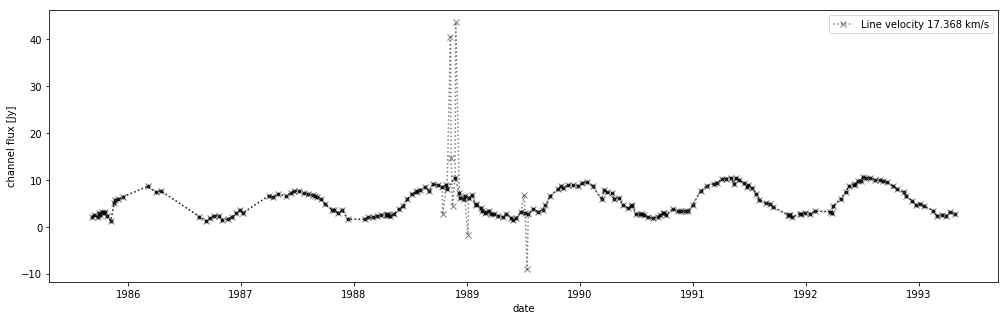

In [11]:
fig, ax = show_output.timeseries(ts_jd.datetime,
                                 blue_spectrum,
                                 label = 'Line velocity {} km/s'.format(blue_velocity),
                                 color='k',
                                 marker='x',
                                 alpha=0.5,
                                )
fig, ax = show_output.timeseries(smoother_blue_ts.datetime,
                                 smoother_blue_spectrum,
                                 color='k',
                                 marker='.',
                                 alpha=0.7,
                                 fig=fig,
                                 ax=ax,
                                )
ax.set_xlabel('date')
ax.set_ylabel('channel flux [Jy]')
plt.show()

The remaining "outlier" should be evaluated manually to ensure it is a true outlier and removed if necessary.

In [12]:
[fitted_trend,
 outlier_idx] = clean_channel(ts_jd.value,
                              red_spectrum,
                              window=21,
                              threshold=3.5,
                              order=3,
                              niter=100,
                              smooth_method='sg')
smoother_red_spectrum = red_spectrum[~outlier_idx]
smoother_red_ts = ts_jd[~outlier_idx]

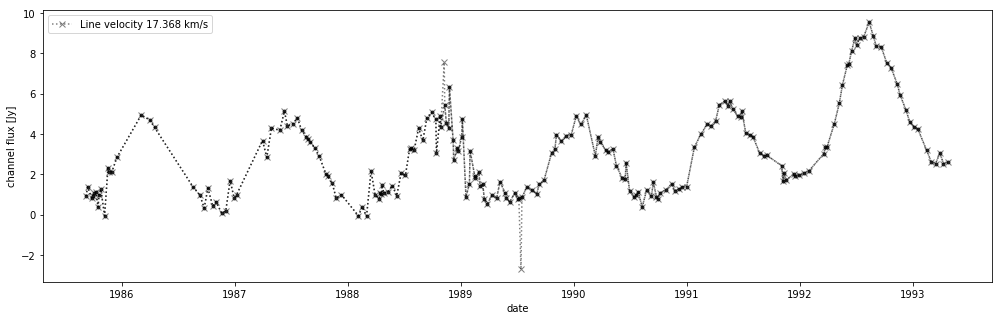

In [13]:
fig, ax = show_output.timeseries(ts_jd.datetime,
                                 red_spectrum,
                                 label = 'Line velocity {} km/s'.format(blue_velocity),
                                 color='k',
                                 marker='x',
                                 alpha=0.5,
                                )
fig, ax = show_output.timeseries(smoother_red_ts.datetime,
                                 smoother_red_spectrum,
                                 color='k',
                                 marker='.',
                                 alpha=0.7,
                                 fig=fig,
                                 ax=ax,
                                )
ax.set_xlabel('date')
ax.set_ylabel('channel flux [Jy]')
plt.show()

Validation of success of cleaning methodology through visual comparison with manually cleaned data

In [14]:
# read input data assuming HartRAO format
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input('data/iktausMWch_blue_red_channels.tscat',
                   epoch=0,
                   tsformat='mjd')
blue_spectrum = spectra[:, 0]
blue_velocity = chan_vel[0]
red_spectrum = spectra[:, 1]
red_velocity = chan_vel[1]
jd_datetime = ts_jd.datetime

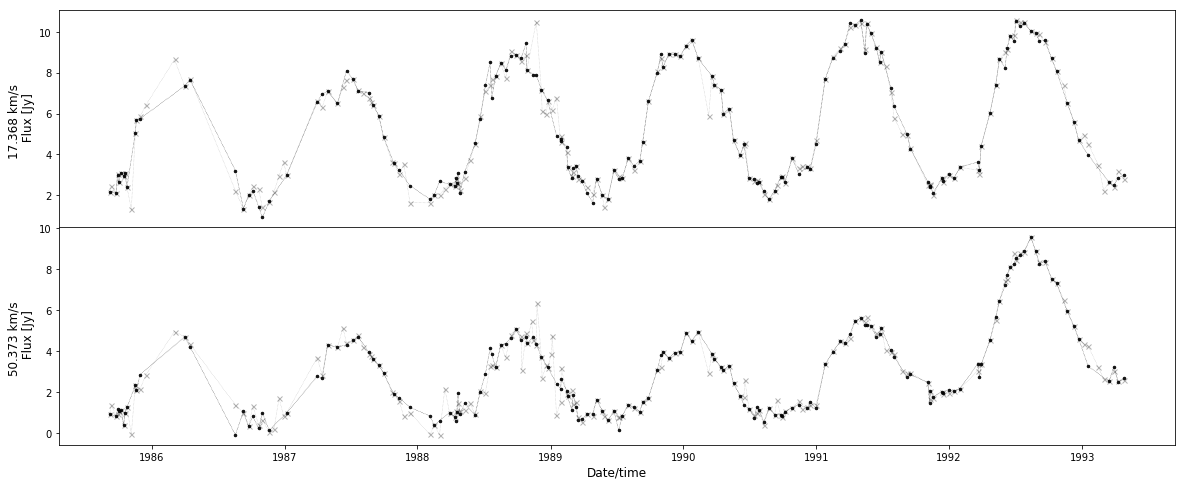

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1,
                       figsize=(20,8),
                       facecolor='white')
fig.set_canvas(plt.gcf().canvas)
plt.subplots_adjust(hspace=0,wspace=0)
ax[0].plot(smoother_blue_ts.datetime,
           smoother_blue_spectrum,
           color='k',marker='x', linestyle=':', linewidth=0.5, markersize=5,
           alpha=0.3)
ax[0].plot(jd_datetime, blue_spectrum,
           color='k', marker='.', linestyle=':', linewidth=0.5, markersize=5,
           alpha=0.9)
ax[0].set_ylabel('{} km/s \n Flux [Jy]'.format(blue_velocity),
                 fontsize=12)

ax[1].plot(smoother_red_ts.datetime,
          smoother_red_spectrum,
          color='k',marker='x', linestyle=':', linewidth=0.5, markersize=5,
          alpha=0.3)
ax[1].plot(jd_datetime, red_spectrum,
          color='k', marker='.', linestyle=':', linewidth=0.5, markersize=5,
          alpha=0.9)
ax[1].set_ylabel('{} km/s \n Flux [Jy]'.format(red_velocity),
                 fontsize=12)

ax[1].set_xlabel('Date/time', fontsize=12)
plt.show()

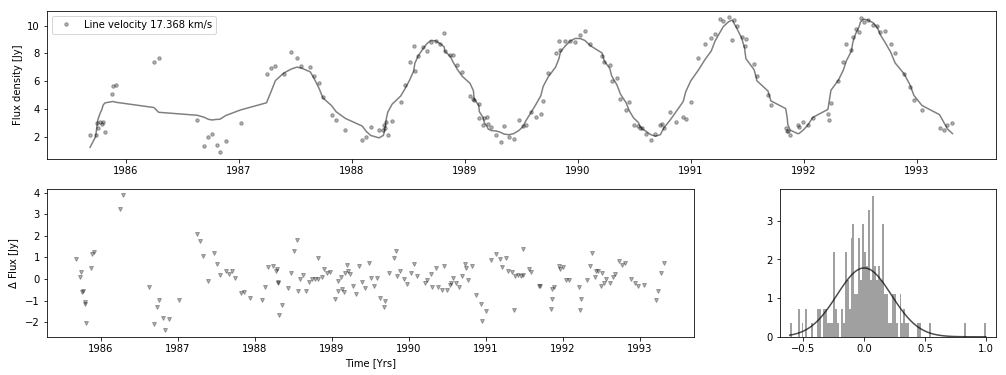

In [16]:
from scipy.signal import savgol_filter as savitzky_golay
import matplotlib.mlab as mlab

smoothed_curve = savitzky_golay(blue_spectrum, 21, 3)
residual = blue_spectrum - smoothed_curve
norm_data = np.apply_along_axis(func1d=lambda x: x/np.max(residual), arr=residual, axis=0)

fig= plt.subplots(figsize=(17,6),
                  facecolor='white')
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[0,:])
ax0.plot(jd_datetime, blue_spectrum,
         color='k', marker='.', linestyle='none', markersize=7, alpha=0.3,
         label=r'Line velocity {} km/s'.format(blue_velocity))
ax0.plot(ts_jd.datetime, smoothed_curve,
         color='k', marker=',', linestyle='-', markersize=0, alpha=0.5)
ax0.legend(loc=0)
ax0.set_ylabel('Flux density [Jy]')

ax1 = plt.subplot(gs[1, 0])
ax1.plot(jd_datetime, residual,
         color='k', marker='v', linestyle='none', markersize=4, alpha=0.3)
ax1.set_xlabel('Time [Yrs]')
ax1.set_ylabel(r'$\Delta$ Flux [Jy]')

# the histogram of the data to check that sample noise is gaussion (white)
ax2 = plt.subplot(gs[1, 1])
ax2.hist(norm_data, 100, density=1, facecolor='gray', alpha=0.75)
mean = np.mean(norm_data)
variance = np.var(norm_data)
sigma = np.sqrt(variance)
x = np.linspace(min(norm_data), max(norm_data), 100)
ax2.plot(x, mlab.normpdf(x, mean, sigma),
         color='k', marker=',', linestyle='-', markersize=0, alpha=0.7)

plt.show()

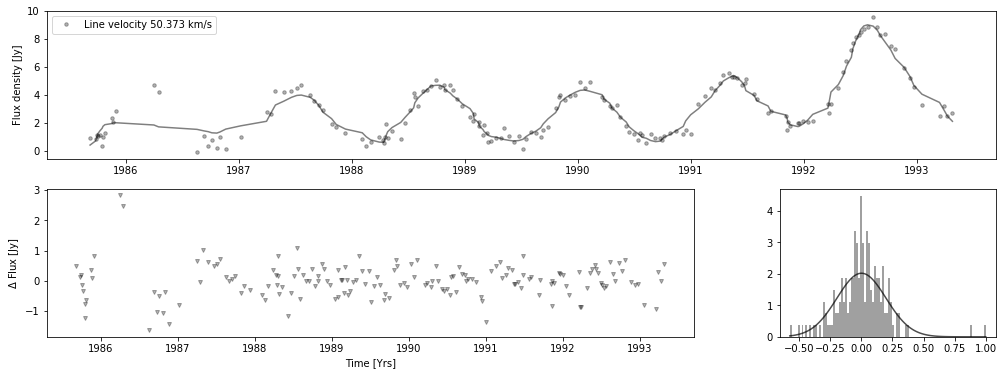

In [17]:
smoothed_curve = savitzky_golay(red_spectrum, 21, 3)
residual = red_spectrum - smoothed_curve
norm_data = np.apply_along_axis(func1d=lambda x: x/np.max(residual), arr=residual, axis=0)

fig= plt.subplots(figsize=(17,6),
                  facecolor='white')
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])
ax0 = plt.subplot(gs[0,:])
ax0.plot(jd_datetime, red_spectrum,
         color='k', marker='.', linestyle='none', markersize=7, alpha=0.3,
         label=r'Line velocity {} km/s'.format(red_velocity))
ax0.plot(ts_jd.datetime, smoothed_curve,
         color='k', marker=',', linestyle='-', markersize=0, alpha=0.5)
ax0.legend(loc=0)
ax0.set_ylabel('Flux density [Jy]')

ax1 = plt.subplot(gs[1, 0])
ax1.plot(jd_datetime, residual,
         color='k', marker='v', linestyle='none', markersize=4, alpha=0.3)
ax1.set_xlabel('Time [Yrs]')
ax1.set_ylabel(r'$\Delta$ Flux [Jy]')

# the histogram of the data to check that sample noise is gaussion (white)
ax2 = plt.subplot(gs[1, 1])
ax2.hist(norm_data, 100, density=1, facecolor='gray', alpha=0.75)
mean = np.mean(norm_data)
variance = np.var(norm_data)
sigma = np.sqrt(variance)
x = np.linspace(min(norm_data), max(norm_data), 100)
ax2.plot(x, mlab.normpdf(x, mean, sigma),
         color='k', marker=',', linestyle='-', markersize=0, alpha=0.7)

plt.show()